# Paper
This is reproducing the analysis from Zheng et al (stick paper here) to understand the overall workflow.

## Vascular Dementia vs Control
For identifying genes that were differentially expressed between vascular dementia (VaD) and non-VaD controls, they used pre-existing gene expression dataset from the GEO database, GSE122063. 

In [1]:
# Import libraries used by GEO2R
library(GEOquery)
library(limma)
library(umap)

library(ggplot2)
library(tidyverse)
library(EnhancedVolcano)


Loading required package: Biobase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind, colnames, dirname, do.call, duplicated, eval, evalq, Filter,
    Find, get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff, table, tapply, union, unique, unsplit,
    which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with 'browseVignettes()'. To cite Bioconductor, see 'citation("Biobase")',
    and for packages 'citation("pkgname")'.

Setting options('download.file.method.GEOquery'='auto')
Setting options('GEOquery.inmemory.gpl'=FALSE)

Attaching package: ‘limma’

The following object is mask

Warning message:
package ‘umap’ was built under R version 4.4.3 


Learn more about the underlying theory at https://ggplot2-book.org/


Warning message:
package ‘ggplot2’ was built under R version 4.4.3 


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
ℹ Use the ]8;;http://conflicted.r-lib.org/conflicted package]8;; to force all conflicts to become errors


Warning messages:
1: package ‘tidyverse’ was built under R version 4.4.3 
2: package ‘tibble’ was built under R version 4.4.3 
3: package ‘purrr’ was built under R version 4.4.3 
4: package ‘stringr’ was built under R version 4.4.3 
5: package ‘forcats’ was built under R version 4.4.3 


Loading required package: ggrepel


Warning message:
package ‘ggrepel’ was built under R version 4.4.3 


This section is pulled from the generated GEO2R code

In [2]:
#this pulls GSE122063 as an ExpressionSet object
gset_122063 <- getGEO("GSE122063", GSEMatrix =TRUE, AnnotGPL=FALSE)

# GPL16699 refers to the platform it was on, according to GEO and this is what GEO2R did so I'm replicating it here
if (length(gset_122063) > 1) idx <- grep("GPL16699", attr(gset_122063, "names")) else idx <- 1
gset_122063 <- gset_122063[[idx]]

# make proper column names to match toptable 
fvarLabels(gset_122063) <- make.names(fvarLabels(gset_122063))

Found 1 file(s)
GSE122063_series_matrix.txt.gz


So GEO2R is a GUI that allows you to directly select samples and then it runs the analysis for you. It performs subsetting like this: 

In [3]:
## group membership for all samples
#gsms <- paste0("000000000000000000000000000000000000XXXXXXXXXXXXXX",
#        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX11111111",
#        "111111111111111111111111111111111111")
#
#sml <- strsplit(gsms, split="")[[1]]
#
## filter out excluded samples (marked as "X")
#sel <- which(sml != "X")
#sml <- sml[sel]
#gset <- gset[ ,sel]

This makes sense if you're using a GUI interface to select your samples, but if you're not we can do it this way. First, lets look at what our ExpressionSet object looks like

In [4]:
gset_122063

ExpressionSet (storageMode: lockedEnvironment)
assayData: 58717 features, 136 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM3454053 GSM3454054 ... GSM3454188 (136 total)
  varLabels: title geo_accession ... tissue:ch1 (47 total)
  varMetadata: labelDescription
featureData
  featureNames: 4 5 ... 62972 (58717 total)
  fvarLabels: ID COL ... SEQUENCE (19 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 30990880 
Annotation: GPL16699 

In particular, we're interested in the phenoData. This contains the names of the sample (sampleNames) as well as the metadata about said samples in varLabels.

In [5]:
varLabels(gset_122063)

 [1] "title"                   "geo_accession"           "status"                  "submission_date"         "last_update_date"       
 [6] "type"                    "channel_count"           "source_name_ch1"         "organism_ch1"            "characteristics_ch1"    
[11] "characteristics_ch1.1"   "characteristics_ch1.2"   "characteristics_ch1.3"   "characteristics_ch1.4"   "characteristics_ch1.5"  
[16] "characteristics_ch1.6"   "molecule_ch1"            "extract_protocol_ch1"    "label_ch1"               "label_protocol_ch1"     
[21] "taxid_ch1"               "hyb_protocol"            "scan_protocol"           "description"             "description.1"          
[26] "description.2"           "description.3"           "data_processing"         "platform_id"             "contact_name"           
[31] "contact_email"           "contact_department"      "contact_institute"       "contact_address"         "contact_city"           
[36] "contact_state"           "contact_zip/postal_code

This dataset contains samples from controls, patients with VaD, and patients with Alzheimer's disease (AD). This paper only looked at the first two groups, so we want to remove the AD samples from this dataset. More specifcally, we want to create a subset with only controls and VaD samples.

In [6]:
# the disease information the "patient diagnosis:ch1" column
gset_122063$`patient diagnosis:ch1`

  [1] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
  [7] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [13] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [19] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [25] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [31] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [37] "Alzheimer's disease" "Alzheimer's disease" "Alzheimer's disease" "Alzheimer's disease" "Alzheimer's disease" "Alzheimer's disease"
 [43] "Alzheimer's disease" "Alzhe

In [7]:
#So lets subset for only VaD and controls

VaD_v_ctrl <- gset_122063[, gset_122063$`patient diagnosis:ch1` %in% c("Control","Vascular dementia")]
VaD_v_ctrl

ExpressionSet (storageMode: lockedEnvironment)
assayData: 58717 features, 80 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM3454053 GSM3454054 ... GSM3454188 (80 total)
  varLabels: title geo_accession ... tissue:ch1 (47 total)
  varMetadata: labelDescription
featureData
  featureNames: 4 5 ... 62972 (58717 total)
  fvarLabels: ID COL ... SEQUENCE (19 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 30990880 
Annotation: GPL16699 

Now when we look at the patient diagnosis in this subset that we have created, we only have samples labeled as VaD or control.

In [8]:
table(VaD_v_ctrl$`patient diagnosis:ch1`)


          Control Vascular dementia 
               44                36 

In [9]:
VaD_v_ctrl$groups <- ifelse(VaD_v_ctrl$`patient diagnosis:ch1` == "Control","ctrl","VaD") #Assign VaD or control based on diagnosis
VaD_v_ctrl$groups <- factor(VaD_v_ctrl$groups)
table(VaD_v_ctrl$groups)


ctrl  VaD 
  44   36 

In [10]:
VaD_v_ctrl$groups

 [1] VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD 
[28] VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl
[55] ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl
Levels: ctrl VaD

In [11]:
design <- model.matrix(~ VaD_v_ctrl$groups)
fit <-lmFit(VaD_v_ctrl, design)
fit <- eBayes(fit)
res_Vad_Ctrl <- topTable(fit, adjust="fdr", sort.by="B", number=250)
full_res_VaD_ctrl <- topTable(fit, adjust="fdr", sort.by="B", number=Inf)
res_Vad_Ctrl <- subset(res_Vad_Ctrl, select=c("ID","adj.P.Val","P.Value","t","B","logFC","SPOT_ID","GB_ACC","SEQUENCE"))
head(res_Vad_Ctrl)

Removing intercept from test coefficients
Removing intercept from test coefficients


         ID    adj.P.Val      P.Value         t        B      logFC       SPOT_ID       GB_ACC
2078   2078 1.837537e-22 3.129481e-27 -16.26668 50.77325 -0.9809206  A_23_P254353    NM_006647
9648   9648 8.306204e-20 2.829233e-24  14.53628 44.30563  0.8083234 A_33_P3378920 NM_001198845
21888 21888 5.255357e-19 2.685095e-23 -13.98455 42.15574 -1.5233886  A_23_P142322    NM_001280
33998 33998 1.177764e-18 8.108094e-23 -13.71695 41.09797 -1.0672392 A_33_P3211864    NR_028407
53404 53404 1.177764e-18 1.002916e-22 -13.66571 40.89432 -2.5096632 A_33_P3349827    NM_006743
59714 59714 1.504970e-18 1.537855e-22 -13.56293 40.48475 -1.9993493  A_23_P148308    NM_006743
                                                          SEQUENCE
2078  ATGGCTGGAGGGCCACTGTGACGGCCGCATCGGCATCTTCCCCAAGTGCTTCGTGGTCCC
9648  ACTGCTCCAGGGTCTCTTTTTGGTCCAAAGGCTAGACCTATAGAGTTGGATCACTTTTTT
21888 TCAAGATCGTCCTTCCAATGGCTGTGTGTTTAAAGATTGTGGGAGCTTCGCTGAACGTTA
33998 TCTCATAATCTTGCATATACCTCTGTAAGTAGTCCCTACATTAAAGTCCCTTGAACCATC


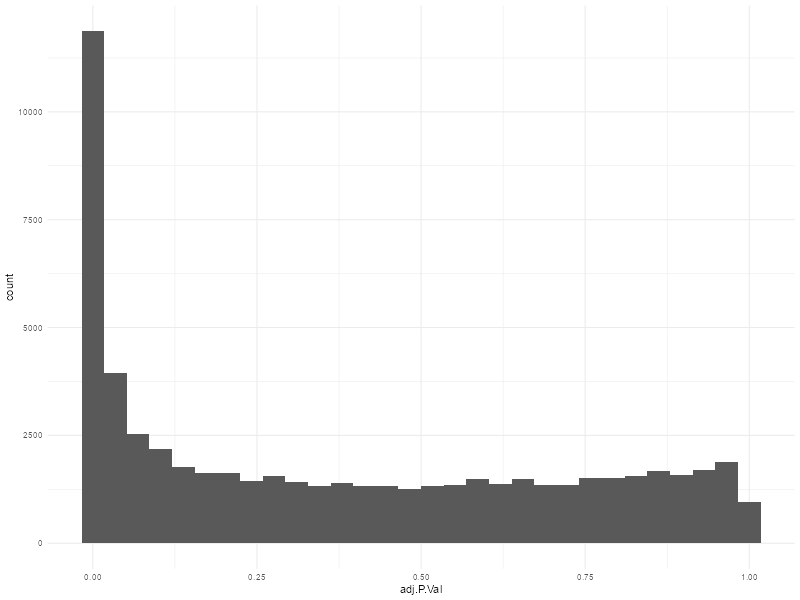

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.

In [12]:
full_res_VaD_ctrl |>
  ggplot(aes(x = adj.P.Val)) +
    geom_histogram() +
    theme_minimal()

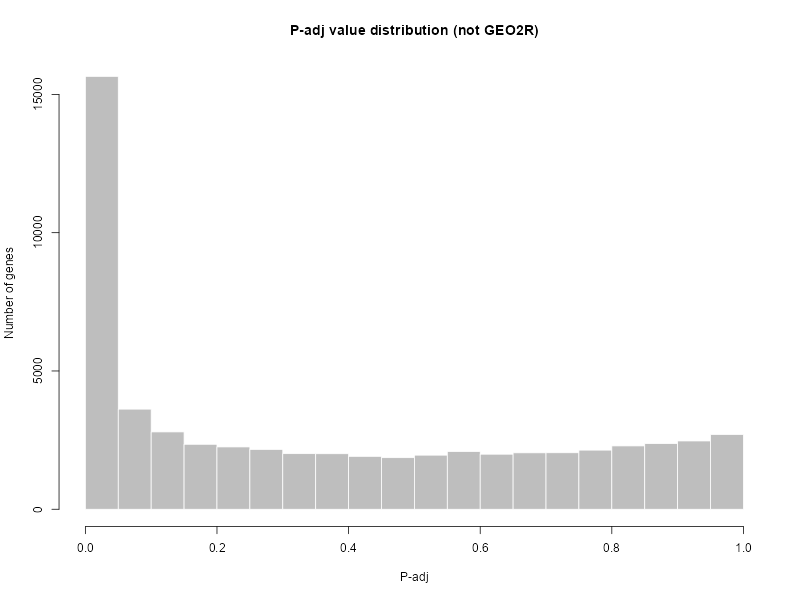

In [13]:
hist(full_res_VaD_ctrl$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
  ylab = "Number of genes", main = "P-adj value distribution (not GEO2R)")

This paper defined a gene as differentially expressed if it had an adjusted p-value less that 0.05 and the absolute value of logFC greater than 1. So we'll utilize the same cutoffs here.

In [14]:
sig_VaD_ctrl <- full_res_VaD_ctrl  |>
  filter(adj.P.Val < 0.05) |>
  filter(abs(logFC) > 1) |>
  mutate(direction = ifelse(logFC > 0, "up", "down")) 

table(sig_VaD_ctrl$direction)


down   up 
 448  265 

Using the cutoffs provided in Zheng et al, we've identified 713 differentially expressed genes (DEGs) (448 downregulated in VaD, 265 upregulated in VaD) associated with VaD. This is slightly concerning given that the paper identified 373. This could be one of three things:
- I messed up! 
- I used the wrong dataset
- There are additional parameters/cutoffs that were used in the analysis

In the interim, lets create a volanco plot. For this, I'm using EnhancedVolcano, because I like the customizable aspect of it.

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


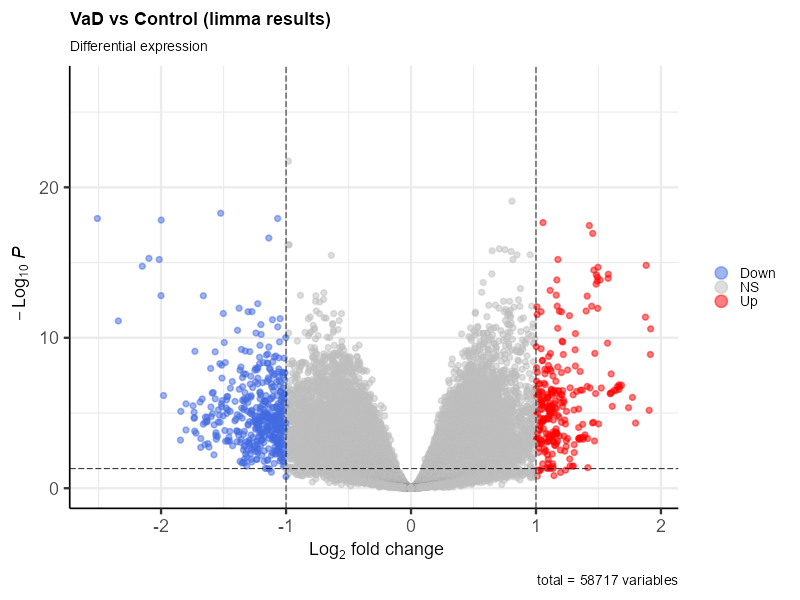

In [29]:
keyvals <- ifelse(
    full_res_VaD_ctrl$logFC < -1, 'royalblue',
      ifelse(full_res_VaD_ctrl$logFC > 1, 'red',
        'gray'))
  keyvals[is.na(keyvals)] <- 'gray'
  names(keyvals)[keyvals == 'red'] <- 'Up'
  names(keyvals)[keyvals == 'gray'] <- 'NS'
  names(keyvals)[keyvals == 'royalblue'] <- 'Down'

base_fig <- EnhancedVolcano(full_res_VaD_ctrl,
  lab = NA,
  x = 'logFC',
  y = 'adj.P.Val',
  pCutoff = 0.05,
  legendPosition = 'right',
  title = 'VaD vs Control (limma results)',
  subtitle = "Differential expression",
  colCustom = keyvals)

base_fig + 
  scale_x_continuous(
    breaks = seq(-2,2,1)
  )